In this workbook, I apply the Periodic Kernel to test case 19, variation 1, and test case 7, variation 1

In [1]:
test_case_list = [7, 19]
variation_list = [1, 1]



First, I import GPy, a Python library for GPR implementations. I also get a function to help me make training data based on test case and variation numbers

In [2]:
cd ../

/home/riddhisw/Documents/2017/Scripts_Git


In [3]:
import GPy, numpy as np 
from matplotlib import pyplot as plt
from gprtf.common import get_data # we will make training data using get_data

def trainingdata(test_case, variation):
    x, y, testx, truth, n_predict= get_data(test_case, variation, 
                                        randomize='y')
    num = truth.shape[0]
    X = x[0:n_train,np.newaxis]
    Y = y[0:n_train,np.newaxis]
    return X, Y, testx, truth

The optimisation problem over all 4 parameters for GPR is difficult. We link the periodicity and the lengthscale to the longest and shortest timescales of the system during training.

Namely:
    - p = N_train
    - l = 3 * Delta T 
    
Sigma (kernel / process noise variance) and R (Kalman msmt noise variance) orders were estimated from optimisation during Kalman filtering and manual tuning

We note that if the optimal periodicity >> N_train or N, the algorithm tends to pick l <<< Delta T, and a failure results.

We recreate this failure by constraining periodicity a small distance away from n_train.

Test Case 7, 1 (Four Fourier Components) and Test Case 19, 1 (Severely Undersampled 'White' Noise with 1% SNR) with the following parameters:

    - n_train = 2000
    - Delta_T = 0.001
    - sigma = 1.0
    - R =  1.0
    - SigmaMax = 1000.0 
    - Rmax = 30.0

We then confirm that the procedure to narrow the optimisation problem (as above) works by:

    - Case A: unconstrained Periodicity
    - Case B: m1.std_periodic.period.constrain_bounded(1970, 1971)
    - Case C: m1.std_periodic.period.constrain_bounded(2075, 2076)

In [4]:
# Set parameters
n_train = 2000
Delta_T = 0.001
n_predict = 100
n_testbefore=50

In [5]:
# Set initial starting values for L-BFGS-B OPtimiser in GPy
sigma_0 = 1.0
R_0 =  1.0

In [6]:
# Set bounds for L-BFGS-B Optimiser when searching for R, Sigma
SigmaMx = 1000.0 
RMx = 30.0

In [7]:
# Set length scale and periodicity initial values for L-BFGS-B OPtimiser in GPy
length_scale_0 = 3.0*Delta_T
period_0 = 2000.0

In [8]:
# Implement artificial bounds for periodicity
B_min = 1970
B_max = 1971
C_min = 2075
C_max = 2076

In [9]:
CASES = ['A', 'B', 'C']
COLORS = ['b', 'g', 'teal']
CASES_min = [None, B_min, C_min]
CASES_max = [None, B_max, C_max]
CONSTRAINT = [0, -30.5, 75.5]
print CASES_min, CASES_max

[None, 1970, 2075] [None, 1971, 2076]


('Shapes', 200, 200, (150,))


 gprtf/common.py:32: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 gprtf/common.py:33: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 /home/riddhisw/anaconda2/lib/python2.7/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200, 200, (150,))
('Shapes', 200

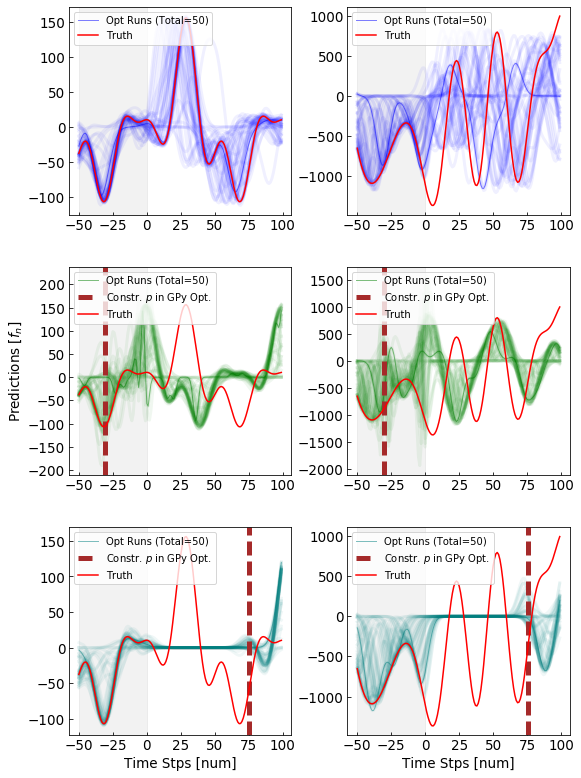

In [10]:
import matplotlib.gridspec as gridspec
import svgutils.transform as sg

fsize=13.5
my_dpi=400
ver=0

gs = gridspec.GridSpec(3, 2,
                       left=0.12, right=0.99, 
                       top=0.99, bottom=0.07, 
                       wspace=0.25, hspace=0.25)

fig = plt.figure(figsize=(8,11))

for idx_tc in xrange(2):
    
    test_case = test_case_list[idx_tc]
    variation = variation_list[idx_tc]
    
    for idx_cases in xrange(3):

        pred_list = []
        GPR_opt_params=[]

        ax = fig.add_subplot(gs[idx_cases, idx_tc])

        for idx_runs in xrange(50):

            X, Y, testx, truth = trainingdata(test_case, variation)
            kernel_per = GPy.kern.StdPeriodic(1, period=period_0, variance=sigma_0, lengthscale=length_scale_0)
            gauss = GPy.likelihoods.Gaussian(variance=R_0)
            exact = GPy.inference.latent_function_inference.ExactGaussianInference()
            m1 = GPy.core.GP(X=X, Y=Y, kernel=kernel_per, likelihood=gauss, inference_method=exact)
            m1.std_periodic.variance.constrain_bounded(0, SigmaMx)
            m1.Gaussian_noise.variance.constrain_bounded(0, RMx)

            if idx_cases !=0:
                m1.std_periodic.period.constrain_bounded(CASES_min[idx_cases], CASES_max[idx_cases])

            # Optimise GPy Model
            #print('Run: ', idx_runs)
            #print('Before Optimisation: ', [m1.std_periodic.variance[0], m1.Gaussian_noise.variance[0], m1.std_periodic.period[0], m1.std_periodic.lengthscale[0]])
            m1.optimize()
            GPR_opt_params.append([m1.std_periodic.variance[0], m1.Gaussian_noise.variance[0], m1.std_periodic.period[0], m1.std_periodic.lengthscale[0]])
            #print('After Optimisation: ', [m1.std_periodic.variance[0], m1.Gaussian_noise.variance[0], m1.std_periodic.period[0], m1.std_periodic.lengthscale[0]])
            pred_list.append(m1.predict(testx[:,np.newaxis])[0].flatten())

            if idx_runs==0:
                plt.plot(range(-n_testbefore, n_predict, 1), pred_list[idx_runs], '-', 
                     c=COLORS[idx_cases], lw=1.0, alpha=0.5, label = 'Opt Runs (Total=50)')
            plt.plot(range(-n_testbefore, n_predict, 1), pred_list[idx_runs], '-', 
                     c=COLORS[idx_cases], lw=3, alpha=0.06)

        if idx_cases !=0:
            ax.axvline(x=CONSTRAINT[idx_cases], ls='--', lw=5, c='brown', label=r'Constr. $p$ in GPy Opt.')

        ax.axvspan(-n_testbefore, 0, color='gray', alpha=0.1)
        ax.plot(range(-n_testbefore, n_predict, 1), truth[n_train - n_testbefore : ], 'r', label='Truth')
        #ax.set_title('Case '+CASES[idx_cases]) #+', Testcase %s Var %s RMax %s SigMax %s' %(test_case, variation, RMx, SigmaMx))
        ax.legend(loc=2)

        if idx_cases==2:
            ax.set(xlabel='Time Stps [num]')
        if idx_cases==1 and idx_tc==0:
            ax.set(ylabel=r'Predictions [$f_n$]')
        ax.tick_params(direction='in', which='both')
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fsize)

plt.show()
fig.savefig('GPRP_PeriodDemo_'+str(ver)+'.svg', format='svg', dpi=my_dpi)
plt.close()

In [13]:
#create new SVG figure
fig = sg.SVGFigure("590px", "810px")
subfig1 = sg.fromfile('GPRP_PeriodDemo_'+str(ver)+'.svg')

# get the plot objects
plot1 = subfig1.getroot()
plot1.moveto(0, 20, scale=1.0)

# add text labels
txt1 = sg.TextElement(45, 15, "A*", size=18, font='Arial', weight="bold")
txt2 = sg.TextElement(340, 15, "C(ii)", size=18, font='Arial', weight="bold")

num1 = sg.TextElement(15, 30, "(i)", size=18, font='Arial', weight="bold")
num2 = sg.TextElement(15, 290, "(ii)", size=18, font='Arial', weight="bold")
num3 = sg.TextElement(15, 550, "(iii)", size=18, font='Arial', weight="bold")

# append plots and labels to figure
fig.append([plot1])
fig.append([txt1, txt2, num1, num2, num3])

# assign filenames to SVG files
filename ="compiled_fig_9_ver_"+str(ver)
filenamesvg = './Notes_2017_v4/img/'+filename+".svg"
filenamepdf = './Notes_2017_v4/img/'+filename+'.pdf'

fig.save(filenamesvg)

!inkscape --file=$filenamesvg --export-area-drawing --export-pdf=$filenamepdf --export-latex